# Исследование надёжности заёмщиков

Нам доступны данные от кредитного отдела банка с информацией о клиентах и наличии у них задолженностей по возврату кредитов. 
Требуется определить, влияет ли семейное положение, количество детей, уровень дохода и цель кредита на факт погашения кредита в срок.

Описание данных:
* *children* — количество детей в семье
* *days_employed* — трудовой стаж в днях
* *dob_days* — возраст клиента в годах
* *education* — образование клиента
* *education_id* — идентификатор образования
* *family_status* — семейное положение
* *family_status_id* — идентификатор семейного положения
* *gender* — пол клиента
* *income_type* — тип занятости
* *debt* — имел ли задолженность по возврату кредитов
* *total_income* — доход в месяц
* *purpose* — цель получения кредита

## Знакомство с данными

In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

from pymystem3 import Mystem
from collections import Counter

In [2]:
data = pd.read_csv('/datasets/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Из сводки по таблице видим, что в столбцах `days_employed` и `total_income` мы столкнемся с пропущенными значениями. Количество пропущенных значений велико (2174, то есть около 10% от общего размера датасета) и совпадает. Необходимо проверить, связаны ли пропуски в этих двух столбцах между собой и с данными из других столбцов. И заполнить пропуски в `total_income`. Было бы хорошо понять природу этих пропусков.

Также, очевидно, тип данных для столбца `days_employed` выбран неверно, мы ожидали увидеть там целочисленный тип.

In [3]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Первое, на что обращаем внимание - избыточность данных. Необходимо найти связь между возвратом кредита в срок и информацией о наличии детей, семейным положением, уровнем дохода и целью кредита. Таким образом, информация о трудовом стаже, возрасте клиента, его образовании, поле и типе занятости нам не должна пригодиться. 

Второе, на что обращаем внимание - странные значения в столбце `days_employed` (трудовой стаж): часть величин имеет отрицательные значения, часть - неправдоподобно большие (например, 5 строка: 340266 дней - это около 930 лет). В текущей постановке задачи эти данные нас не интересуют. Но необходимо уточнить, каким образом собираются эти данные. 

Третье - различия в регистре в столбце `education`: Среднее/среднее. 

Четвертое - данные в столбце `purpose` потребуют проведения лемматизации и категоризации.

Рассмотрим столбцы по-отдельности на предмет поиска аномалий.

In [4]:
for name in data.columns:
    display(name)
    display(data[name].value_counts())

'children'

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

'days_employed'

-986.927316     1
-7026.359174    1
-4236.274243    1
-6620.396473    1
-1238.560080    1
               ..
-2849.351119    1
-5619.328204    1
-448.829898     1
-1687.038672    1
-582.538413     1
Name: days_employed, Length: 19351, dtype: int64

'dob_years'

35    617
40    609
41    607
34    603
38    598
42    597
33    581
39    573
31    560
36    555
44    547
29    545
30    540
48    538
37    537
50    514
43    513
32    510
49    508
28    503
45    497
27    493
56    487
52    484
47    480
54    479
46    475
58    461
57    460
53    459
51    448
59    444
55    443
26    408
60    377
25    357
61    355
62    352
63    269
64    265
24    264
23    254
65    194
66    183
22    183
67    167
21    111
0     101
68     99
69     85
70     65
71     58
20     51
72     33
19     14
73      8
74      6
75      1
Name: dob_years, dtype: int64

'education'

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

'education_id'

1    15233
0     5260
2      744
3      282
4        6
Name: education_id, dtype: int64

'family_status'

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

'family_status_id'

0    12380
1     4177
4     2813
3     1195
2      960
Name: family_status_id, dtype: int64

'gender'

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

'income_type'

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
в декрете              1
студент                1
Name: income_type, dtype: int64

'debt'

0    19784
1     1741
Name: debt, dtype: int64

'total_income'

112874.418757    1
133912.272223    1
182036.676828    1
122421.963500    1
198271.837248    1
                ..
133299.194693    1
115080.782380    1
84896.781597     1
153838.839212    1
150014.128510    1
Name: total_income, Length: 19351, dtype: int64

'purpose'

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
покупка жилья для сдачи                   653
операции с жильем                         653
операции с коммерческой недвижимостью     651
покупка жилья                             647
жилье                                     647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
покупка своего жилья                      620
строительство недвижимости                620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

Аномалии:
1. Столбец `children`.
Присутствуют значения `-1` и `20`. 
Гипотеза: опечатки при ручном вводе данных. 
Предлагаемое решение: заменить `-1` на `1`, `20` - на `2`.

2. Столбец `dob_years`. Присутствует значение `0`. В текущей постановке задачи эти данные нас не интересуют. Оставим его без изменений. Необходимо выяснить причину появления таких данных в датасете. 

3. Столбец `education`. Вероятно, из-за ручного ввода часть значений введена в нижнем регистре, часть - в верхнем. На это мы уже обращали внимание раньше. Это категориальная переменная, есть смысл реализовать ввод этих данных выбором из ограниченного списка, а не ручным вводом. Для дальнейшей работы данные приведем к нижнему регистру.

4. Столбец `gender`. Присутствует значение `XNA`. Оно одно и в текущей постановке задачи нас не интересует. Оставим его без изменений. 

Со столбцом `purpose`, как и ожидалось, необходимо провести лемматизацию и категоризацию.
Столбцы `days_employed` и `total_income` содержат неповторяющиеся значения, для них проведем дополнительный анализ: найдём среднее, медиану, минимум, максимум.

In [5]:
columns = ['days_employed', 'total_income']
operations = ['min', 'max', 'mean', 'median']
for column in columns:
    display(data.agg({column: operations}))

,days_employed
min,-18388.949901
max,401755.400475
mean,63046.497661
median,-1203.369529


,total_income
min,2.066726e+04
max,2.265604e+06
mean,1.674223e+05
median,1.450179e+05


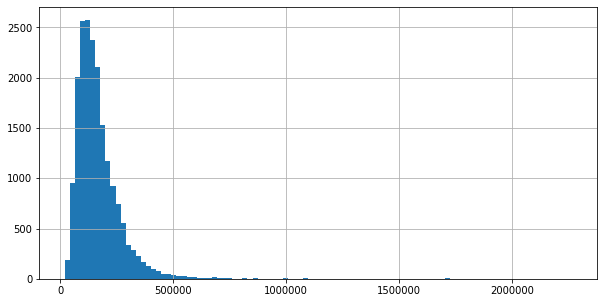

In [6]:
h_total_income_before = data['total_income'].hist(bins=100, figsize=(10, 5))

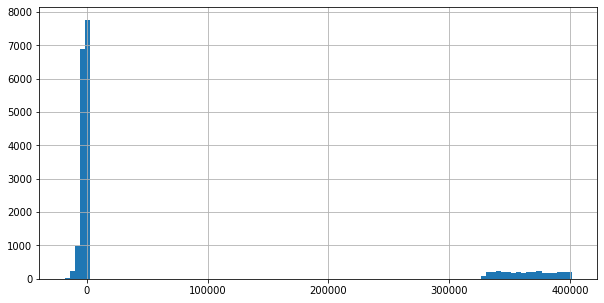

In [7]:
data['days_employed'].hist(bins=100, figsize=(10, 5))

Видим, что данные по стажу разбиваются на две отдельные группы: небольшие значения меньше нуля и очень большие значения больше нуля. Посмотрим на них подробнее.

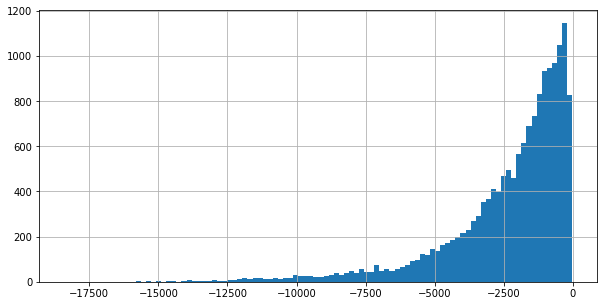

In [8]:
data[data['days_employed'] < 0]['days_employed'].hist(bins=100, figsize=(10, 5))

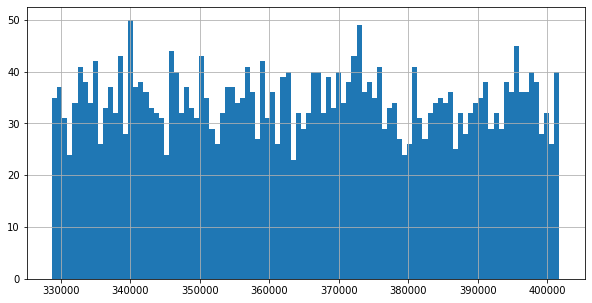

In [9]:
data[data['days_employed'] > 0]['days_employed'].hist(bins=100, figsize=(10, 5))

Данные `total_income` имеют разумные крайние значения и достаточно близкие значения среднего и медианы. Распределение выглядит в целом разумно.

Данные `days_employed` разбиваются на две группы: (1) небольшие отрицательные значения и (2) очень большие положительные значения. Гипотеза: первая группа - реальные стаж, который по какой-то причине оказался отрицательным (максимальное абсолютное значение - около 18500, что соответствует примерно 50 годам (= 18500 / 365). Вторая группа - возможно, заполнение неизвестных значений заведом большими числами: и абсолютно значение и дельта между минимальным и максмальным значением при переводе в года слишком большие. Но это не согласуется с наличием пропусков в данном столбце.

**Вывод**

Предложенный нам датасет с информацией содержит данные о 21525 клиентах, которые представлены в 12 колонках. На первый взгляд в рамках поставленной задачи данные избыточны. Необходимая для анализа информация нам предоставлена: наличие задолженности по возврату кредита (`debt`), информация о наличии детей (`children`), семейном положении (`family_status`, `family_status_id`), уровне дохода (`total_income`) и цель кредита (`purpose`). Кроме этого предоставлена информация о трудовом стаже (`days_employed`), возрасте клиента (`dob_days`), его образовании (`education`, `education_id`), поле (`gender`) и типе занятости (`income_type`).

1. В датасете есть пропуски в информации о трудовом стаже (`days_employed`) и доходах (`total_income`). Количество пропусков достаточно большое - около 10% и пропуски затрагивают критичный для анализа столбец с данными о доходе клиентов. Необходимо проверить, связаны ли пропуски в этих двух столбцах между собой и с данными из других столбцов. И заполнить пропуски в total_income.

2. Необходимо изменить тип данных в столбце `days_employed` на целочисленный.

3. Необходимо разобраться с регистром в информации об образованиии (`education`). Для дальнейшей работы приведем данные к нижнему регистру. 

4. После этого проверим, есть ли в в датасете дубликаты и разберемся с ними.

5. Необходимо провести лемматизацию и категоризацию данных о целях получения кредита (`purpose`).

6. Скорректировать ошибки в информации о детях (`children`). Мы предполагаем наличие опечаток при вводе и планируем заменить значения следующим образом: `-1` на `1`, `20` - на `2`.


Вопросы/предложения к коллегам, предоставившим данные:
1. Уточнить, каким образом собирались данные о трудовом стаже (`days_employed`): непонятно, как правильно интерпретировать полученные данные. Проблемы: отрицательные значения и неправдоподобно большие значения.
2. Обсудить возможные причины пропусков в данных о трудовом стаже(`days_employed`) и доходах(`total_income`). Возможно, пропуски взаимосвязаны.
3. При сборе данных об образовании предложить изменить ввод данных с ручного ввода на выбор из ограниченного списка, чтобы избежать возникновения дублей.
4. При сборе данных о количестве детей предложить добавить проверку на разумность введенного значения (положительное и не слишком большое), либо изменить ручной ввод данных на выбор из предложенных вариантов (включая вариант "другое" с ручным вводом).
5. При сборе данных о возрасте клиента предложить ввести проверку на разумность введенного значения (в датасете присутствуют нулевые значения данного параметра).
6. Обратить внимание на наличие значения `XNA` в данных о поле клиента.


## Предобработка данных

### Обработка пропусков

#### Обнаружение связи между пропусками в разных столбцах

Посмотрим на строки, содержащие пропуски в `days_employed`.

In [10]:
data[data['days_employed'].isnull()]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Среднее,1,женат / замужем,0,M,компаньон,0,NaN,сделка с автомобилем
21495,1,NaN,50,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,свадьба
21497,0,NaN,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,NaN,строительство недвижимости
21502,1,NaN,42,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,строительство жилой недвижимости


Мы получили ожидаемое количество строк (21525 - 19351 = 2174). Заметим, что строки с пропусками в `days_employed` содержать пропуски в `total_income`. 

Гипотеза: пропуски в этих столбцах связаны и появляются одновременно. Для проверки этой гипотезы посчитаем строки, содержащие два пропуска одновременно. Ожидаем получить 2174 таких строки.


In [11]:
condition = (data['days_employed'].isnull()) & (data['total_income'].isnull())
data[condition].count()

children            2174
days_employed          0
dob_years           2174
education           2174
education_id        2174
family_status       2174
family_status_id    2174
gender              2174
income_type         2174
debt                2174
total_income           0
purpose             2174
dtype: int64

Мы получили 2174 строки с отсутствующими данными в `days_employed` и `total_income`. Значит, пропуски идут парами. Гипотеза: пропуски связаны неоформленными трудовыми отношениями. Посмотрим на тип занятости этих людей:

In [12]:
probe = data[condition].groupby('income_type')
probe.count()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,debt,total_income,purpose
income_type,,,,,,,,,,,
госслужащий,147,0,147,147,147,147,147,147,147,0,147
компаньон,508,0,508,508,508,508,508,508,508,0,508
пенсионер,413,0,413,413,413,413,413,413,413,0,413
предприниматель,1,0,1,1,1,1,1,1,1,0,1
сотрудник,1105,0,1105,1105,1105,1105,1105,1105,1105,0,1105


Гипотеза не подтвердилась, но мы получили список типов занятости, в которых есть пропуски в информации о доходе. Сохраним этот список для дальнейшего использования.

In [13]:
lost_income_type = []
for row in probe:
    lost_income_type += [row[0]]
display(lost_income_type)

['госслужащий', 'компаньон', 'пенсионер', 'предприниматель', 'сотрудник']

#### Заполнение пропусков 

Перед заполнением пропущенных значений создадим столбец `total_income_flag`, который сохранит информацию о том, является ли значение реальным (True) и восстановленным (False), чтобы информация об этом сохранилась. Для такого заполнения метод *.isna()* не подойдет, поэтому будем использовать метод *.notna()*.

In [14]:
data['total_income_flag'] = data['total_income'].notna()
data['total_income_flag'].value_counts()

True     19351
False     2174
Name: total_income_flag, dtype: int64

Для заполнения пропусков в данных о месячном доходе, найдем медианные значения дохода для разных типов занятости и разного пола клиентов. Еще посчитаем размер выборки, по которой мы находим медианное значение, чтобы понимать, насколько можно доверять этим данным. Сами данные сохраним в список *lost_income_type_gender_mediana_count* для дальнейшего использования.

In [15]:
data.groupby(['income_type', 'gender'])['total_income'].agg(['median', 'count'])

median  count
income_type     gender                      
безработный     F       202722.511368      1
                M        59956.991984      1
в декрете       F        53829.130729      1
госслужащий     F       136982.489425    962
                M       185964.946748    350
компаньон       F       160820.776207   2870
                M       196818.800823   1706
                XNA     203905.157261      1
пенсионер       F       115807.789733   2806
                M       130739.759955    637
предприниматель F       499163.144947      1
                M                 NaN      0
сотрудник       F       130615.610597   6111
                M       162161.177474   3903
студент         M        98201.625314      1

Видим, что доход зависит не только от типа занятости, но и от пола, поэтому для заполнения пропусков сохраним медианные значения для каждой пары признаков, кроме предпринимателя, т.к. в этой группе у нас только одна запись с известным доходом. В этом случае правильным будет не пытаться заполнить пропуск, а удалить строку с неизвестным доходом из рассмотрения.  Заполним средними значениями все пропуски остальных, а после этого удалим из датафрейма строку с предпринимателем с неизвестным доходом.

In [16]:
data['total_income'] = data['total_income'].fillna(
    data.groupby(['income_type', 'gender'])['total_income'].transform('mean'))

In [17]:
data[data['total_income'].isna()]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_flag
5936,0,NaN,58,высшее,0,женат / замужем,0,M,предприниматель,0,NaN,покупка жилой недвижимости,False


Проверили, что осталась только одна запись с NaN в `total_income`. Удалим её.

In [18]:
data.dropna(subset=['total_income'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21524 entries, 0 to 21524
Data columns (total 13 columns):
children             21524 non-null int64
days_employed        19351 non-null float64
dob_years            21524 non-null int64
education            21524 non-null object
education_id         21524 non-null int64
family_status        21524 non-null object
family_status_id     21524 non-null int64
gender               21524 non-null object
income_type          21524 non-null object
debt                 21524 non-null int64
total_income         21524 non-null float64
purpose              21524 non-null object
total_income_flag    21524 non-null bool
dtypes: bool(1), float64(2), int64(5), object(5)
memory usage: 2.2+ MB


**Вывод**

1. Мы заполнили пропущенные значения по ежемесячному доходу медианными значениями по группам "тип занятости"-"пол". 
2. Одного клиента из группы "предприниматель"-"Маle" пришлось удалить из рассмотрения, т.к. было невозможно сделать предположение о его доходе. 

### Замена типа данных

Неправильный тип данных мы видим только в столбце `days_employed`. Однако, в рамках поставленных вопросов, этот эти данные нас не интересуют. 

Если бы они нас интересовали, то мы, ожидая корреляции стажа с возрастом, проверили бы эту гипотезу и при потверждении, разбили бы клиентов на категории по возрасту и заполнили пропуски в данных о стаже медианными значениями стажа для разных возрастных группа. После этого использовали бы метод *.astype('int')* для приведения данных к целочисленному типу, т.к. данные изначально имеют численный тип.

### Обработка дубликатов

Для начала приведем к единому регистру данные об образовании клиентов, т.к. разный регистр может замаскировать дубли.

In [19]:
data['education'].value_counts()

среднее                13750
высшее                  4717
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

In [20]:
data['education'] = data['education'].str.lower()
data['education'].value_counts()

среднее                15233
высшее                  5259
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

Теперь вместо 15 категорий, имеем 5. 

Ищем дубликаты и удаляем:

In [21]:
dupl_quan = data.duplicated().sum()
display(str(dupl_quan)+ ' дубликат; ' + str(round(100* dupl_quan/len(data), 3)) + '% от общего количества.')

'71 дубликат; 0.33% от общего количества.'

In [22]:
data = data.drop_duplicates().reset_index(drop=True)

In [23]:
data.duplicated().sum()

0



**Вывод**

1. При сборе данных об образовании предложить изменить ввод данных с ручного ввода на выбор из ограниченного списка, чтобы избежать возникновения дублей.
2. Количество дубликатов невелико (около 0.33%). Необходимо выяснить источник дубликатов. Гипотеза: дублирование происходит при поступлении одной заявки по разным каналам.

### Лемматизация

In [24]:
m = Mystem()

data['purpose'].value_counts(dropna=False)

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
покупка жилья                             646
жилье                                     646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                605
на покупку своего автомобиля              505
заняться высшим образованием      

In [25]:
lemma_dict = {}
def lemmatizator(row):
    if row not in lemma_dict:
        lemma_dict[row] = m.lemmatize(row)
    return lemma_dict[row]

data['lemma_purpose'] = data['purpose'].apply(lemmatizator)
data['lemma_purpose'].value_counts()

[автомобиль, \n]                                          972
[свадьба, \n]                                             791
[на,  , проведение,  , свадьба, \n]                       768
[сыграть,  , свадьба, \n]                                 765
[операция,  , с,  , недвижимость, \n]                     675
[покупка,  , коммерческий,  , недвижимость, \n]           661
[операция,  , с,  , жилье, \n]                            652
[покупка,  , жилье,  , для,  , сдача, \n]                 651
[операция,  , с,  , коммерческий,  , недвижимость, \n]    650
[покупка,  , жилье, \n]                                   646
[жилье, \n]                                               646
[покупка,  , жилье,  , для,  , семья, \n]                 638
[строительство,  , собственный,  , недвижимость, \n]      635
[недвижимость, \n]                                        633
[операция,  , со,  , свой,  , недвижимость, \n]           627
[строительство,  , жилой,  , недвижимость, \n]            624
[покупка

**Вывод**

Лемматизация целей взятия кредита прошла успешно, на следующем шаге проведем категоризацию.

Т.к. лемматизация - ресурсозатратный процесс и среди целей кредита большое количество полных повторов, было принято решение хранить пары "строка"-"результат лемматизации" в отдельном словаре и перед запуском лемматизации сначала проверять, нет ли готового результата для данной строки. Это должно способствовать для ускорению процесса лемматизации большого массива данных с большим количеством повторов.

### Категоризация данных

#### Категоризация цели кредита

In [26]:
data['lemma_purpose'].value_counts()

[автомобиль, \n]                                          972
[свадьба, \n]                                             791
[на,  , проведение,  , свадьба, \n]                       768
[сыграть,  , свадьба, \n]                                 765
[операция,  , с,  , недвижимость, \n]                     675
[покупка,  , коммерческий,  , недвижимость, \n]           661
[операция,  , с,  , жилье, \n]                            652
[покупка,  , жилье,  , для,  , сдача, \n]                 651
[операция,  , с,  , коммерческий,  , недвижимость, \n]    650
[покупка,  , жилье, \n]                                   646
[жилье, \n]                                               646
[покупка,  , жилье,  , для,  , семья, \n]                 638
[строительство,  , собственный,  , недвижимость, \n]      635
[недвижимость, \n]                                        633
[операция,  , со,  , свой,  , недвижимость, \n]           627
[строительство,  , жилой,  , недвижимость, \n]            624
[покупка

Из списка выше хорошо выделяются три категории - автомобиль, свадьба, образование. Выделим сначала их. 

С жильем и недвижимостью сложнее, т.к. кажется разумным разделить коммерцию и собственное жилье/недвижимость. Ими займемся позже

In [27]:
key_words = ['автомобиль', 'свадьба', 'образование']
def purpose_group(row):
    for word in key_words:
        if word in row:
            return word
    return row
data['purpose_key'] = data['lemma_purpose'].apply(purpose_group)
data['purpose_key'].value_counts()        

автомобиль                                                4306
образование                                               4013
свадьба                                                   2324
[операция,  , с,  , недвижимость, \n]                      675
[покупка,  , коммерческий,  , недвижимость, \n]            661
[операция,  , с,  , жилье, \n]                             652
[покупка,  , жилье,  , для,  , сдача, \n]                  651
[операция,  , с,  , коммерческий,  , недвижимость, \n]     650
[жилье, \n]                                                646
[покупка,  , жилье, \n]                                    646
[покупка,  , жилье,  , для,  , семья, \n]                  638
[строительство,  , собственный,  , недвижимость, \n]       635
[недвижимость, \n]                                         633
[операция,  , со,  , свой,  , недвижимость, \n]            627
[строительство,  , жилой,  , недвижимость, \n]             624
[покупка,  , недвижимость, \n]                         

Дальше выделим тех, кто планирует заработать денег на цели кредита: коммерческая недвижимость или жилье под сдачу. Ключевые слова - 'сдача' и 'коммерческий', помечаем как 'инвестиции'.

In [28]:
key_words = ['сдача', 'коммерческий']
def purpose_group(row):
    for word in key_words:
        if word in row:
            return 'инвестиции'
    return row
data['purpose_key'] = data['purpose_key'].apply(purpose_group)
data['purpose_key'].value_counts() 

автомобиль                                              4306
образование                                             4013
свадьба                                                 2324
инвестиции                                              1962
[операция,  , с,  , недвижимость, \n]                    675
[операция,  , с,  , жилье, \n]                           652
[покупка,  , жилье, \n]                                  646
[жилье, \n]                                              646
[покупка,  , жилье,  , для,  , семья, \n]                638
[строительство,  , собственный,  , недвижимость, \n]     635
[недвижимость, \n]                                       633
[операция,  , со,  , свой,  , недвижимость, \n]          627
[строительство,  , жилой,  , недвижимость, \n]           624
[покупка,  , недвижимость, \n]                           621
[покупка,  , свой,  , жилье, \n]                         620
[строительство,  , недвижимость, \n]                     619
[ремонт,  , жилье, \n]  

Выделим последние две группы: по ключевым словам 'жилье', 'жилой', 'собственный', 'свой' выделим группу 'жилье'.

In [29]:
key_words = ['жилье', 'жилой', 'собственный', 'свой']
def purpose_group(row):
    for word in key_words:
        if word in row:
            return 'жилье'
    return row
data['purpose_key'] = data['purpose_key'].apply(purpose_group)
data['purpose_key'].value_counts() 

жилье                                    6300
автомобиль                               4306
образование                              4013
свадьба                                  2324
инвестиции                               1962
[операция,  , с,  , недвижимость, \n]     675
[недвижимость, \n]                        633
[покупка,  , недвижимость, \n]            621
[строительство,  , недвижимость, \n]      619
Name: purpose_key, dtype: int64

Остальных выделяем в группу 'недвижимость'. 

In [30]:
key_words = ['недвижимость']
def purpose_group(row):
    for word in key_words:
        if word in row:
            return 'недвижимость'
    return row
data['purpose_key'] = data['purpose_key'].apply(purpose_group)
display(data['purpose_key'].value_counts())
display('Всего в категориях: ' + str(data['purpose_key'].value_counts().sum()))

жилье           6300
автомобиль      4306
образование     4013
недвижимость    2548
свадьба         2324
инвестиции      1962
Name: purpose_key, dtype: int64

'Всего в категориях: 21453'

#### Категоризация уровня дохода

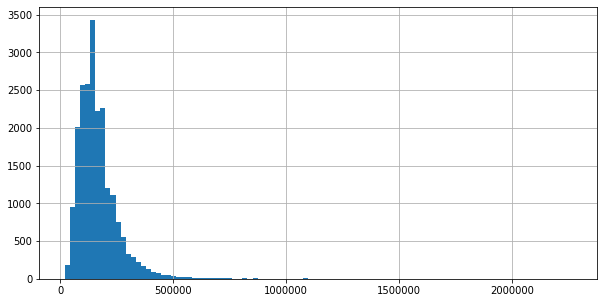

In [31]:
h_total_income_after = data['total_income'].hist(bins=100, figsize=(10, 5))

Разобьем всех клиентов на 4 группы по доходу, используя в качестве границ квартили 25%, 50% и 75%.

In [32]:
display('Границы групп')
display(data['total_income'].describe()[4:7])
data['total_income_group_q'] = pd.qcut(data['total_income'], 4, labels=['low','medium', 'meduim+', 'hi'])

'Границы групп'

25%    107620.948105
50%    148863.158984
75%    198632.396188
Name: total_income, dtype: float64

**Вывод**

1. Категоризация целей кредита прошла успешно. В результате мы получили 6 групп размером от примерно 10% до 30% от исходной выборки: 'жилье', 'автомобиль', 'образование', 'недвижимость', 'свадьба', 'инвестиции'. 

    При выделении групп где-то мы использовали прямую привязку по основному существительному: 'образование', 'свадьба', 'автомобиль'. С недвижимость и жильем работали иначе: сначала выделили группу 'инвестиции' по ключевым словам 'сдача' и 'коммерческий', потом выделили группу 'жилье' по ключевым словам 'жилье', 'жилой', 'собственный', 'свой', и последняя группа - недвижимость. В эту группу вошли запросы, которые к какой группе отнести - недвижимость для последующего заработка на ней ('инвестиции') или для собственного использования ('жилье').


2. Категоризацию дохода проведена по квартилям. Получили 4 группы клиентов: 'low' - доход меньше 108 тыс.рублей, 'medium' - доход от 108 до 144 тыс.рублей, 'medium+' - доход от 144 до 197 тыс.рублей, 'hi' - доход от 197 тыс.рублей.

## Характеристики, влияющие на возврат кредита в срок 

In [33]:
data['debt'].mean()

0.08115415093460122

Начнем с того, что найдем средний процент задолженостей по рассматриваемой выборке. Он оказался равным примерно 8.1%.

### Связь между наличием детей и возвратом кредита в срок

Для начала избавимся от ошибочных значений в данных о наличии детей: заменим значения '20' на '2' и '-1' на '1', как это обсуждалось ранее.

In [34]:
data.loc[data['children'] == 20, 'children'] = 2
data.loc[data['children'] == -1, 'children'] = 1
data['children'].value_counts()

0    14090
1     4855
2     2128
3      330
4       41
5        9
Name: children, dtype: int64

Создадить столбец `have_children`, который будет отражать факт наличия (1) или отсутствия (0) детей. 
После этого посмотрим, какова вероятность задолженности в случае, если дети есть, и в случае, если детей нет.

In [35]:
def have_children(counter):
    if counter > 0:
        if counter > 2:
            return '>2'
        else:
            return '1-2'
    else:
        return '0'

data['have_children'] = data['children'].apply(have_children)
data.groupby('have_children')['debt'].agg(['mean', 'count'])

,mean,count
have_children,,
0,0.075444,14090
1-2,0.092654,6983
>2,0.081579,380


**Вывод**

Видно, что при наличии детей вероятность задолженности выше. При этом у многодетных вероятность несколько ниже:
1. Есть дети (1-2) - 9.2% 
2. Нет детей - 7.5%
3. Многодетные (>2) - 8.6%


Гипотеза:  там, где бездетный клиент мог бы сократить расходы с целью выплаты кредита, родитель будет экономить менее охотно, т.к. на детях стараются не экономить.

### Связь между семейным положение и возвратом кредита в срок

Данные о семейном положении уже сгруппированы. Посчитаем вероятность задоженности по каждой группе.

In [36]:
data.groupby('family_status')['debt'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

,mean,count
family_status,,
Не женат / не замужем,0.097509,2810
гражданский брак,0.093471,4151
женат / замужем,0.075458,12338
в разводе,0.071130,1195
вдовец / вдова,0.065693,959


**Вывод**

Получившиеся вероятности для разных семейных статусов (в порядке убывания вероятности задолженности):
1. Не женат / не замужем - 9.8%
2. гражданский брак	- 9.3%
3. женат / замужем	- 7.5%
4. в разводе - 7.1%
5. вдовец / вдова - 6.5%

Видно, что есть группировка по вероятности задолженности: люди не состоявшие в официальном браке ("Не женат / не замужем" и "гражданский брак") с большей вероятностью будут иметь задолженность (9.3-9.8%), чем те, кто в нем состоит/стоял ("женат / замужем", "в разводе", "вдовец / вдова", вероятность задолженности в интервале 6.5-7.5%).

### Связь между уровнем дохода и возвратом кредита в срок

In [37]:
data.groupby('total_income_group_q')['debt'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

,mean,count
total_income_group_q,,
meduim+,0.088317,5050
medium,0.085976,5676
low,0.079605,5364
hi,0.070856,5363


Здесь напрашивается вывод о том, что хуже всего отдают кредиты люди со средним доходом. Но вспомним, что мы заполнили 
порядка 10% процентов данных о доходе медианными значениями, которые должны были попасть как раз в средние группы. 
Возможно, плохо отдают кредиты те люди, информация о доходах которых отсутствует. Найдем процент задолженностей для них. У этих людей в `total_income_flag` значение = False.

In [38]:
data[data['total_income_flag'] == False]['debt'].mean()

0.08087535680304472

Гипотеза не подтвердилась: средняя вероятность задолженности у людей, данных о доходе которых у нас не было, около 8.1%, то есть они, попадая в группы 'medium' и  'medium+', своим присутствием улучшали показатели этих групп.

**Вывод**

Вероятность задолженности в зависимости от уровня дохода:
1. Группа 'low' (доход меньше 108 тыс.рублей) - 8.0%
2. Группа 'medium' (доход от 108 до 144 тыс.рублей) - 8.5%
3. Группа 'medium+' (доход от 144 до 197 тыс.рублей) - 8.8%
4. Группа 'hi' (доход от 197 тыс.рублей) - 7.1%

Видно, что самый высокий уровень задолженности показывают группы с доходами выше среднего (8.8%) и со средним уровнем дохода (8.5%).

Лучший результат показывает группа 'hi' с самым высоким уровнем дохода (процент задолженности - 7.1%). Можно предположить, что у этой группы выше средняя сумма кредита и уровень финансового планирования.

Группа с самым низким уровнем дохода ('low') имеет промежуточный процент задолженности выше (8.0%). Можно предположить, то эта группа (по сравнению с группой со средним доходом) лучше контролирует свой бюджет и более рационально распоряжается финансами.

При этом процент задолженности у людей с отсутвующей информацией о доходах - 8.0%, что близко к среднему уровню.

### Связь между целью кредита и его возвратом

In [39]:
data.groupby('purpose_key')['debt'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

,mean,count
purpose_key,,
автомобиль,0.093590,4306
образование,0.092200,4013
свадьба,0.080034,2324
инвестиции,0.076962,1962
недвижимость,0.076138,2548
жилье,0.069365,6300


**Вывод**

Вероятность задолженности в зависимости от цели кредита:
1. автомобиль - 9.4%
2. образование - 9.2%
3. свадьба - 8.0%
4. инвестиции - 7.7%
5. недвижимость	- 7.6%
6. жилье - 6.9%

Видно, что наименьшая вероятность возникновения задолженности у групп, цель кредита которых связана с недвижимостью ("инвестиции", "недвижимость", "жилье"). При этом наиболее аккуратными плательщиками являются те, кого мы отнесли к группе "жилье", то есть те, кто берет кредит на недвижимость для дальнейшего проживания в ней.

Можно было ожидать, что наибольший процент задолженностей будет у тех, кто берет кредит на свадьбу, но их с серьезным отрывом опережают те, кто берет кредит на образование или цели, связанные с автомобилями.

## Вывод

Портрет идеального клиента:
1. Нет детей;
2. Состоит или состоял в официальном браке;
3. Имеет высокий уровень дохода (от 197 тыс.рублей/месяц);
4. Цель кредита - собственное жилье.

Портрет потенциально проблемного клиента:
1. Есть дети;
2. Не состоит в официальном браке;
3. Средний уровень дохода (от 108 до 197 тыс.рублей/месяц);
4. Цель кредита - автомобиль или образование.


